PROJECT

Deliverables:
    Notebook
    Documentation of the model
    Test that everything works well
Goals:
    Compare the environmental performance of 2 biobased insulation materials contrasted to a reference fossil insulation      material, applied     to buildings throught the prodution and end-of-life phases of the product.
Scope:
    The environmental performance is assessed through the climate change (CO2, Ch4, N2O), water use, and land use (area occupied) impacts
    LCIA method: 
    The assessment is performed for 50 years of lifetime of the buildings
    The EoL choices involve incineration, landfill, composting, and mulching (we are going to consider 2)
    Temporal scope:
    
Tools
    Github
    Temporalis
    Excel

  *How to consider the soil carbon sequestration/release/lost effect
  For croplands is shor, for forests is large


In [ ]:
from bw_temporalis import easy_timedelta_distribution, easy_datetime_distribution, TemporalisLCA, Timeline, TemporalDistribution
from bw_temporalis.lcia import characterize_methane, characterize_co2

import bw2io as bi 
import bw2data as bd
import bw2calc as bc
import os               # to use "operating system dependent functionality"
import numpy as np      # "the fundamental package for scientific computing with Python"
import pandas as pd     # "high-performance, easy-to-use data structures and data analysis tools" for Python

In [ ]:
projects.set_current('Buildings Insulation')

In [ ]:
bd.databases

In [ ]:
#our_data = pd.read_csv('LCI.csv')
#our_data.head()

In [ ]:
imp.match_database(fields=('name', 'reference product', 'unit', 'location'))
imp.statistics()

In [ ]:
bi.backup.restore_project_directory(
    fp='brightway2-project-odym-backup.13-November-2024-09-43PM.tar.gz',
    project_name='odym_case'
)

In [ ]:
our_data = bi.ExcelImporter("our_LCI.xlsx")
imp.apply_strategies()
imp.match_database('ecoinvent-3.10-cutoff', fields=('name', 'unit', 'reference product', 'location'))
imp.statistics()

In [12]:
TemporalisLCA?

Init signature:
TemporalisLCA(
    lca_object: bw2calc.lca.LCA,
    starting_datetime: datetime.datetime | str = 'now',
    cutoff: float | None = 0.0005,
    biosphere_cutoff: float | None = 1e-06,
    max_calc: int | None = 2000,
    static_activity_indices: set[int] | None = None,
    skip_coproducts: bool | None = False,
    functional_unit_unique_id: int | None = -1,
    graph_traversal: bw_graph_tools.graph_traversal.new_node_each_visit.NewNodeEachVisitGraphTraversal | None = <class 'bw_graph_tools.graph_traversal.new_node_each_visit.NewNodeEachVisitGraphTraversal'>,
)
Docstring:     
Calculate an LCA using graph traversal, with edges using temporal distributions.

Edges with temporal distributions should store this information using `"temporal_distributions"`:

```python
    exchange["temporal_distribution"] = bw_temporalis.TemporalDistribution(
        times=numpy.array([-2, -1, 0, 1, 2], dtype="timedelta64[s]"),
        values=numpy.ones(5)
    )
```

Temporal distribution tim

In [13]:
TemporalDistribution?

Init signature:
TemporalDistribution(
    date: numpy.ndarray[typing.Any, numpy.dtype[numpy.datetime64 | numpy.timedelta64]],
    amount: numpy.ndarray[typing.Any, numpy.dtype[+ScalarType]],
)
Docstring:     
A container for a series of amount spread over time.
Args:
    * *date* (ndarray): 1D array containg temporal info of `amount` with type `timedelta64` or `datetime64` .
    * *amount* (ndarray): 1D array containg amount with type `float`

    Times and amount must have same length and element of `amount` must correspond to the element of `date`
    with the same index.
File:           c:\users\arendtra\anaconda3\envs\bw25\lib\site-packages\bw_temporalis\temporal_distribution.py
Type:           type
Subclasses:     FixedTimeOfYearTD, FixedTD

In [14]:
Straw_emission_distribution = TemporalDistribution(
                    np.array([0, 1, 50], dtype='timedelta64[Y]'),
                   amount=np.array([0.25, 0.5, 0.25])
                )
EPS_emission_distribution = TemporalDistribution(
                    np.array([ 1, 50], dtype='timedelta64[Y]'),
                    amount=np.array([ 0.75, 0.25])
                )

In [17]:
bd.Database('temporalis-example').write({
    # CO2 emission
    ('temporalis-example', "CO2"): {
        "type": "emission",
        "name": "carbon dioxide",
        "temporalis code": "co2",
    },
    # EPS Production Process
    ('temporalis-example', 'EPS_production'): {
        'exchanges': [
            {
                'amount': 0.8,
                'input': ('temporalis-example', 'CO2'),
                'type': 'biosphere',
                'temporal_distribution': TemporalDistribution(
                    np.array([1], dtype='timedelta64[Y]'),  # Yearly time steps
                    np.array([1])
                ),
            },
        ],
        'name': 'EPS production',
        'type': 'process'
    },
    # EPS End-of-Life Process (Incineration)
    ('temporalis-example', 'EPS_Incineration'): {
        'exchanges': [
            {
                'amount': 0.15,
                'input': ('temporalis-example', 'CO2'),
                'temporal_distribution': TemporalDistribution(
                    np.array([50], dtype='timedelta64[Y]'),  # Emission delayed 50 years
                    np.array([1])
                ),
                'type': 'biosphere'
            },
        ],
        'name': 'EPS Incineration',
        'type': 'process'
    },
    # Functional Unit
    ('temporalis-example', 'Functional Unit - EPS'): {
        'exchanges': [
            {
                'amount': 1,
                'input': ('temporalis-example', 'EPS_production'),
                'type': 'technosphere'
            },
            {
                'amount': 1,
                'input': ('temporalis-example', 'EPS_Incineration'),
                'type': 'technosphere'
            },
        ],
        'name': 'Functional Unit - EPS',
        'type': 'process'
    },
})


16:33:34 [warning  ] Not able to determine geocollections for all datasets. This database is not ready for regionalization.


100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 1998.24it/s]


16:33:34 [info     ] Vacuuming database            


In [19]:
bd.Method(("GWP", "example")).write([
    (('temporalis-example', "CO2"), 1)
])

In [21]:
lca = bc.LCA({('temporalis-example', 'Functional Unit - EPS'): 1}, ("GWP", "example"))
lca.lci()
lca.lcia()

In [22]:
lca = TemporalisLCA(lca)

Starting graph traversal
Calculation count: 2


In [23]:
tl = lca.build_timeline()

In [24]:
df = tl.build_dataframe()
df
#match dataframe to other datatfrmae to display names
#inventory results with the time?

,date,amount,flow,activity
0,2025-11-14 21:25:38,0.80,12,13
1,2074-11-14 18:36:26,0.15,12,14


In [25]:
bd.get_node(id=13), bd.get_node(id=14)
#number of activity is equal to the ID

('EPS production' (None, None, None), 'EPS Incineration' (None, None, None))

<Axes: xlabel='date', ylabel='amount'>

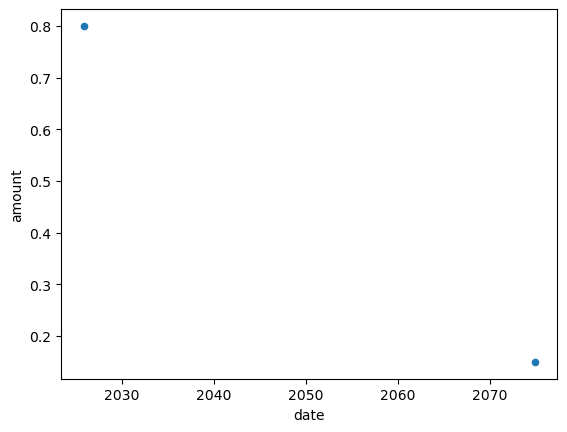

In [26]:
tl.df.plot(x="date", y="amount", kind="scatter")
#does not differentiate between ch4 and co2
#characterize the flows
#more important to reduce now than later